**Importing libraries**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms, models
import math
import random
import seaborn as sns

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from torch.autograd import Variable as var 


Checking for GPU

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Training on CPU...')
else:
    print('Training on GPU...')
    
    

Training on GPU...


In [3]:
device = torch.device('cuda:0')

In [4]:
df_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [5]:
print('Train size: ', df_train.shape)
print('Test size: ', df_test.shape)
df_train.head()

Train size:  (42000, 785)
Test size:  (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


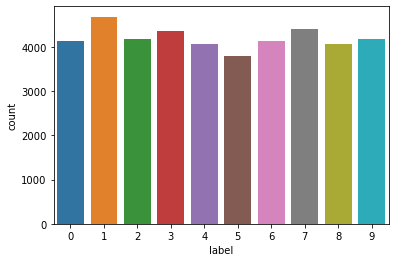

In [7]:
sns.countplot(df_train['label'])

In [8]:
df_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [9]:
df_train.isna().any().any()

False

In [10]:
train_data = df_train.drop('label',axis=1).values

In [11]:
train_data.max()

255

In [12]:
train_data = train_data/255.0
df_test = df_test/255.0

In [13]:
mask = np.random.rand(len(df_train)) < 0.8
df_val = df_train[~mask]
df_train = df_train[mask]
print('Train size: ', df_train.shape)
print('Val size: ', df_val.shape)
print('Test size: ', df_test.shape)
df_train.head()

Train size:  (33425, 785)
Val size:  (8575, 785)
Test size:  (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Create dataset class for PyTorch
class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
                
        image = item[1:].values.astype(np.uint8).reshape((28, 28))
        label = item[0]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [15]:
#Composes several transforms together.
train_transform = transforms.Compose(
                    [
                    #Convert a tensor or an ndarray to PIL Image    
                    transforms.ToPILImage(),
                    #Rotate the image by angle.    
                    #transforms.RandomRotation(30),
                    #Random affine transformation of the image keeping center invariant. 
                    #transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                    #Randomly change the brightness, contrast and saturation of an image.
                    #transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    #Convert a PIL Image or numpy.ndarray to tensor. 
                    transforms.ToTensor(),
                    #Normalize a tensor image with mean and standard deviation. 
                    transforms.Normalize(mean=train_data.mean(), std=train_data.std()),
                    #Horizontally flip the given image randomly with a given probability. 
                    #transforms.RandomHorizontalFlip(p=0.5),
                    #Vertically flip the given image randomly with a given probability. 
                    #transforms.RandomVerticalFlip(p=0.5),
                    #Blurs image with randomly chosen Gaussian blur.
                    #transforms.GaussianBlur(3, sigma=(0.1, 2.0))
                    ])
val_transform = transforms.Compose(
                    [
                    #Convert a tensor or an ndarray to PIL Image    
                    transforms.ToPILImage(),
                    #Rotate the image by angle.    
                    #transforms.RandomRotation(30),
                    #Random affine transformation of the image keeping center invariant. 
                    #transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                    #Randomly change the brightness, contrast and saturation of an image.
                    #transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    #Convert a PIL Image or numpy.ndarray to tensor. 
                    transforms.ToTensor(),
                    #Normalize a tensor image with mean and standard deviation. 
                    transforms.Normalize(mean=train_data.mean(), std=train_data.std()),
                    #Horizontally flip the given image randomly with a given probability. 
                    #transforms.RandomHorizontalFlip(p=0.5),
                    #Vertically flip the given image randomly with a given probability. 
                    #transforms.RandomVerticalFlip(p=0.5),
                    #Blurs image with randomly chosen Gaussian blur.
                    #transforms.GaussianBlur(3, sigma=(0.1, 2.0))
                    ])
test_transform = val_transform

In [16]:
train_dataset = DatasetMNIST(df_train, transform = train_transform)
validation_dataset = DatasetMNIST(df_val, transform = val_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=16)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=16)


In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128, 10),
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = x.view(x.size(0), -1)
        return self.fc(x) 

model = CNN().to(device)






In [18]:
LEARNING_RATE = 0.001680

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [19]:
def train_model(model,train_loader, validation_loader, optimizer, n_epochs=100):
    
    N_test=len(validation_dataset)
    accuracy_list=[]
    loss_list=[]
    for epoch in range(n_epochs):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
        loss_list.append(loss.data)
        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            x_test,y_test = x_test.to(device), y_test.to(device)
            
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
    return accuracy_list, loss_list

In [20]:
accuracy_list, loss_list=train_model(model=model,n_epochs=100,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

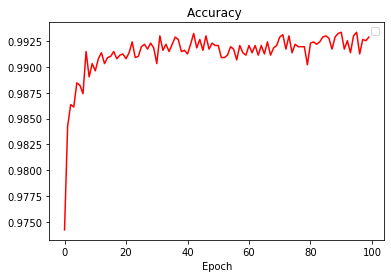

In [21]:
plt.plot(accuracy_list,'r',)
#plt.plot(loss_list,'b')
plt.xlabel('Epoch')
plt.title("Accuracy ")
plt.legend()
plt.show()

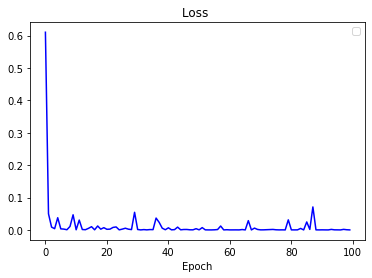

In [22]:
plt.plot(loss_list,'b')
plt.xlabel('Epoch')
plt.title("Loss ")
plt.legend()
plt.show()

In [23]:
print(accuracy_list, loss_list )

[0.9742274052478134, 0.9842565597667638, 0.9863556851311953, 0.9861224489795918, 0.9884548104956268, 0.9882215743440234, 0.9874052478134111, 0.9914868804664723, 0.9890379008746356, 0.9903206997084548, 0.9896209912536443, 0.9907871720116618, 0.9913702623906706, 0.9903206997084548, 0.9909037900874635, 0.9910204081632653, 0.9914868804664723, 0.9907871720116618, 0.9911370262390671, 0.9912536443148688, 0.9907871720116618, 0.9913702623906706, 0.9924198250728863, 0.9909037900874635, 0.9910204081632653, 0.9919533527696793, 0.9921865889212828, 0.9917201166180758, 0.9923032069970845, 0.9918367346938776, 0.9903206997084548, 0.993002915451895, 0.991603498542274, 0.9921865889212828, 0.9914868804664723, 0.9921865889212828, 0.9928862973760932, 0.9926530612244898, 0.9914868804664723, 0.991603498542274, 0.9912536443148688, 0.9921865889212828, 0.9932361516034985, 0.9918367346938776, 0.9926530612244898, 0.991603498542274, 0.993002915451895, 0.9917201166180758, 0.9923032069970845, 0.9920699708454811, 0.99

In [24]:
test_dataset = DatasetMNIST(df_test, transform = val_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=16)

In [25]:
train_mean = train_data.mean()/255.
train_std = train_data.std()/255.
x_test = df_test.values
x_test = x_test.reshape([-1, 28, 28]).astype(np.float)
x_test = x_test/255.
x_test = (x_test-train_mean)/train_std
print(x_test.min())
print(x_test.max())
print(x_test.mean())
print(x_test.std())

-0.42462977802123
2.8164394338725276
-0.0007291270898609053
0.9992572115903888


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_test = np.expand_dims(x_test, axis=1)
x_test = torch.from_numpy(x_test).float().to(device)
# x_test.shape
x_test.type()

'torch.cuda.FloatTensor'

In [27]:
model.eval()   # this is needed to disable dropouts
with torch.no_grad():    # turn off gradient computation because we don't need it for prediction
    ps = model(x_test)
    prediction = torch.argmax(ps, 1)
    print('Prediction',prediction)

Prediction tensor([2, 0, 9,  ..., 3, 9, 2], device='cuda:0')


In [28]:
df_export = pd.DataFrame(prediction.cpu().tolist(), columns = ['Label'])
df_export['ImageId'] = df_export.index +1
df_export = df_export[['ImageId', 'Label']]
df_export.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [29]:
df_export.to_csv('output.csv', index=False)